In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb

In [3]:
import os

In [4]:
file_path = os.path.abspath(os.path.join(os.getcwd(), "."))
data_path = os.path.join(file_path, 'data')

In [5]:
train_data = pd.read_csv(os.path.join(data_path, 'traindata.csv'))
train_label = pd.read_csv(os.path.join(data_path, 'trainlabel.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'testdata.csv'))
test_label = pd.read_csv(os.path.join(data_path, 'testlabel.csv'))


In [7]:

'''
feature_pre_filter默认为True，lightgbm会根据min_data_in_leaf的值提前把一些不可能找到合法分割的特征过滤。
由于后面会调整min_data_in_leaf，我们不希望反复构造数据集，我们将设置feature_pre_filter=False，
这样min_data_in_leaf的选取不会影响到Dataset的构建。
'''
params = {"feature_pre_filter":False}
train_set = lgb.Dataset(train_data, label=train_label, params=params)
test_set = lgb.Dataset(test_data, label=test_label, params=params)

params = {
    'objective':'regression', #设置目标函数为regression，将会使用最小均方误差(MSE)作为目标函数。
    'num_trees':100,
    'verbose':-1
}
early_stopping_rounds=10

num_data_per_day = test_data.shape[0]
val_train_data = train_data.iloc[: -num_data_per_day]
val_test_data = train_data.iloc[-num_data_per_day :]
val_train_label = train_label[: -num_data_per_day]
val_test_label = test_label[-num_data_per_day :]

val_train_set = lgb.Dataset(data=val_train_data, label=val_train_label)
val_test_set = lgb.Dataset(data=val_test_data, label=val_test_label, reference=val_train_set)


In [8]:
def get_eval_result(params):
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=val_train_set,
                      valid_sets=[val_test_set],
                      valid_names=["val_test"],
                      evals_result=evals_result,
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=False)
    return evals_result["val_test"]["l2"][model.best_iteration - 1], model.best_iteration

In [9]:
# train_v1
# 我们发现，num_leaves=8并且min_data_in_leaf=20的时候结果是最好的。接下来我们调整学习率。
def train_v1():
    num_leaves_options = [4, 8, 16]
    min_data_in_leaf_options = [20, 50, 100]
    for num_leaves in num_leaves_options:
        for min_data_in_leaf in min_data_in_leaf_options:
            try_params = params.copy()
            try_params.update({'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf})
            l2, best_iteration = get_eval_result(try_params)
            print("best l2 loss %.6f at iteration %d with num_leaves = %d and min_data_in_leaf = %d" %
                  (l2, best_iteration, num_leaves, min_data_in_leaf))
train_v1()

E:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


best l2 loss 3.760282 at iteration 24 with num_leaves = 4 and min_data_in_leaf = 20
best l2 loss 3.810023 at iteration 25 with num_leaves = 4 and min_data_in_leaf = 50
best l2 loss 3.869175 at iteration 24 with num_leaves = 4 and min_data_in_leaf = 100
best l2 loss 3.689247 at iteration 19 with num_leaves = 8 and min_data_in_leaf = 20
best l2 loss 3.728799 at iteration 19 with num_leaves = 8 and min_data_in_leaf = 50
best l2 loss 3.823588 at iteration 21 with num_leaves = 8 and min_data_in_leaf = 100
best l2 loss 3.698879 at iteration 17 with num_leaves = 16 and min_data_in_leaf = 20
best l2 loss 3.738621 at iteration 18 with num_leaves = 16 and min_data_in_leaf = 50
best l2 loss 3.834497 at iteration 18 with num_leaves = 16 and min_data_in_leaf = 100


In [10]:
# train_v2
# 可见learning_rate=0.05且迭代次数为38是最好的。我们使用搜索出的最优超参，在全部训练集上进行训练，并观察测试集的结果
def train_v2():
    params.update({'num_leaves': 8, 'min_data_in_leaf': 20})
    learning_rate_options = [0.01, 0.02, 0.03, 0.05, 0.1]
    for learning_rate in learning_rate_options:
        try_params = params.copy()
        try_params.update({'learning_rate': learning_rate})
        l2, best_iteration = get_eval_result(try_params)
        print("best l2 loss %.6f at iteration %d with learning_rate = %f" % (l2, best_iteration, learning_rate))
train_v2()

E:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


best l2 loss 4.207344 at iteration 100 with learning_rate = 0.010000
best l2 loss 3.694385 at iteration 97 with learning_rate = 0.020000
best l2 loss 3.692605 at iteration 62 with learning_rate = 0.030000
best l2 loss 3.684798 at iteration 38 with learning_rate = 0.050000
best l2 loss 3.689247 at iteration 19 with learning_rate = 0.100000


In [11]:
# 最优参数
# 得到最终测试集上l2损失函数值为 l2_loss : 3.469563312001725
def train_optimal_parameter():
    params.update({'learning_rate': 0.05, 'num_trees': 38})
    model = lgb.train(params=params,
                      train_set=train_set)
    score = model.predict(test_data)
    print(score)
    print(test_label['label'].to_numpy())
    l2_loss = np.mean((score - test_label['label'].to_numpy()) ** 2)
    print('l2_loss : {}'.format(l2_loss))
    return model

In [12]:
model = train_optimal_parameter()

E:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.99804124 0.45832489 0.68418204 ... 1.05218283 0.97569018 0.95602185]
[0 0 0 ... 0 1 0]
l2_loss : 3.582277849623931


In [13]:
'''
特征重要度：

特征重要性描述每个特征在GBDT模型中的整体贡献。常用的特征重要性计算方法有：

    计算特征在切分条件当中使用的次数。
    计算使用该特征所有切分的增益之和。

二者在LightGBM中都可以通过直接调用模型的feature_importance方法获得。
'''
def print_feature_importance(model, importance_type):
    feature_importance_count = model.feature_importance(importance_type=importance_type)
    feature_names = train_data.columns
    argsort = np.argsort(feature_importance_count)
    for idx in argsort[::-1]:
        print("feature %s with %s %f" % (feature_names[idx], importance_type, feature_importance_count[idx]))

In [14]:
# 按照第1种方法，即特征使用次数（指定importance_type为split）计算特征重要性，并将特征按照重要性排序。
print_feature_importance(model, 'split')

feature p_8 with split 49.000000
feature la_7 with split 41.000000
feature la_21 with split 22.000000
feature la_1 with split 21.000000
feature la_28 with split 21.000000
feature p_5 with split 19.000000
feature p_4 with split 18.000000
feature la_2 with split 13.000000
feature p_6 with split 13.000000
feature la_14 with split 8.000000
feature p_7 with split 7.000000
feature la_42 with split 7.000000
feature la_56 with split 5.000000
feature snap_mean with split 5.000000
feature la_4 with split 4.000000
feature la_3 with split 4.000000
feature p_2 with split 2.000000
feature la_6 with split 2.000000
feature la_5 with split 2.000000
feature p_3 with split 1.000000
feature same_month_mean with split 1.000000
feature p_1 with split 1.000000
feature event_type_2_mean with split 0.000000
feature event_name_1_mean with split 0.000000
feature event_name_2_mean with split 0.000000
feature event_type_1_mean with split 0.000000


In [15]:
# 按照第2种方式，即特征带来的切分增益之和（指定importance_type为gain）计算特征重要性，并将特征按照重要性排序。
print_feature_importance(model, 'gain')

feature la_7 with gain 6620207.672852
feature la_28 with gain 2358621.146973
feature la_21 with gain 2093864.624023
feature p_8 with gain 1732894.020020
feature p_5 with gain 712560.039551
feature p_7 with gain 705762.820801
feature la_3 with gain 601220.500000
feature p_4 with gain 487711.288818
feature la_2 with gain 454794.687988
feature la_1 with gain 395321.317383
feature p_6 with gain 326563.686768
feature la_14 with gain 222743.775879
feature la_5 with gain 166241.719971
feature la_4 with gain 117022.900391
feature la_42 with gain 104273.648682
feature la_56 with gain 62552.350342
feature snap_mean with gain 19040.349731
feature la_6 with gain 12672.319824
feature p_3 with gain 9486.549805
feature p_1 with gain 7354.189941
feature p_2 with gain 5997.360107
feature same_month_mean with gain 3524.129883
feature event_type_2_mean with gain 0.000000
feature event_name_1_mean with gain 0.000000
feature event_name_2_mean with gain 0.000000
feature event_type_1_mean with gain 0.000000


In [16]:
# SHAP值
# 另一个重要的解释工具是SHAP值。它反映了每个特征对每个样本预测值的贡献。LightGBM也提供了SHAP值计算的功能，只需要在调用预测接口predict的时候指定pred_contrib=True即可。

shap_values = model.predict(test_data, pred_contrib=True)
shap = pd.DataFrame(data=shap_values, columns=list(test_data.columns.values) + ["expectation"])
pd.set_option('display.max_columns', None)
shap

# 其中最后一列expectation是训练数据标签的均值。上表中每一行的数值之和等于模型对改行数据的预测值。


,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,la_42,la_56,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean,expectation
0,-0.017412,-0.017210,-0.017329,-0.003757,-0.004766,-0.000079,-0.171047,0.005463,-0.001354,-0.024580,0.053339,-0.001066,-0.000045,0.002566,-0.000196,-0.008893,-0.004476,-0.006493,-0.023412,-0.085424,-0.001081,0.0,0.0,0.0,0.0,-0.011347,1.33664
1,-0.017954,-0.017789,-0.017732,-0.003940,-0.004977,-0.000079,-0.188295,-0.043850,-0.206123,-0.174012,-0.057123,-0.001066,-0.000045,0.002566,-0.000196,-0.008893,-0.004476,-0.006493,-0.023993,-0.091419,-0.001081,0.0,0.0,0.0,0.0,-0.011347,1.33664
2,-0.017412,-0.017210,-0.017526,-0.003757,-0.004977,-0.000079,-0.172157,0.003924,-0.144314,-0.105953,-0.031552,-0.001066,-0.000045,0.002566,-0.000196,-0.008893,-0.004476,-0.006493,-0.023678,-0.086735,-0.001081,0.0,0.0,0.0,0.0,-0.011347,1.33664
3,-0.015960,-0.015394,-0.016797,-0.003395,-0.003586,-0.000079,-0.023160,0.027186,0.300162,0.071686,0.048030,0.061415,-0.000045,-0.000075,-0.000196,-0.009037,-0.005202,-0.006346,-0.027460,0.107283,-0.000388,0.0,0.0,0.0,0.0,-0.014920,1.33664
4,-0.015030,-0.015678,-0.017161,-0.003757,-0.004766,-0.000079,-0.135119,0.032313,-0.001354,-0.023789,0.053339,0.034792,-0.000045,-0.000075,-0.000196,-0.009243,-0.005202,-0.006346,-0.022279,-0.049867,-0.000388,0.0,0.0,0.0,0.0,-0.011347,1.33664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,-0.017201,-0.016434,-0.017732,-0.003940,-0.004977,-0.000079,-0.188295,-0.030490,-0.206123,-0.174012,-0.057123,-0.001066,-0.000045,-0.000075,-0.000196,-0.008993,-0.004476,-0.006493,-0.023993,-0.090889,-0.000388,0.0,0.0,0.0,0.0,-0.011347,1.33664
30486,-0.017954,-0.017789,-0.017732,-0.003757,-0.004977,-0.000079,-0.188295,-0.043850,-0.194327,-0.174012,-0.057123,-0.001066,-0.000045,0.002566,-0.000196,-0.008893,-0.004476,-0.006493,-0.023993,-0.090343,-0.001081,0.0,0.0,0.0,0.0,-0.011347,1.33664
30487,-0.016632,-0.016199,-0.017161,-0.003757,-0.004766,-0.000079,-0.173408,-0.009967,-0.060835,-0.024580,0.053339,0.034792,-0.000045,-0.000075,-0.000196,-0.009243,-0.005202,-0.006493,-0.022279,0.010065,-0.000388,0.0,0.0,0.0,0.0,-0.011347,1.33664
30488,-0.015723,-0.017210,-0.017329,-0.003757,-0.004766,-0.000079,-0.161401,0.005463,-0.060835,-0.024580,0.053339,0.034792,-0.000045,0.002566,-0.000196,-0.009143,-0.005202,-0.006493,-0.023412,-0.094511,-0.001081,0.0,0.0,0.0,0.0,-0.011347,1.33664


<AxesSubplot:>

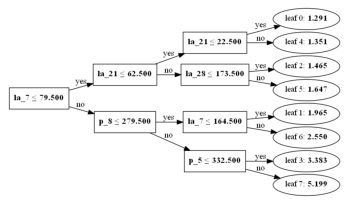

In [18]:
# 使用LightGBM的plot_tree函数可以方便地画出模型中指定决策树的完整结构，包括中间节点上的决策条件和叶子节点的预测值。例如，下面我们画出第一棵树的结构。

lgb.plot_tree(model, tree_index=0)